<a href="https://colab.research.google.com/github/agn2017331008/QML/blob/main/Empirical_quantum_advantage_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

make the balanced dataset


In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap,PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score

seed = 12345
algorithm_globals.random_seed = seed

# Data visualization

In [ ]:
#Explore the files
cancer_targets = pd.read_csv("/content/actual.csv") #targets
cancer_targets['patient'] = cancer_targets['patient'].astype('int')

print(cancer_targets["cancer"].value_counts())
print("\nNumber of samples;", cancer_targets.shape)

ALL    47
AML    25
Name: cancer, dtype: int64

Number of samples; (72, 2)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Class Distributions \n ( AML ||  ALL)')

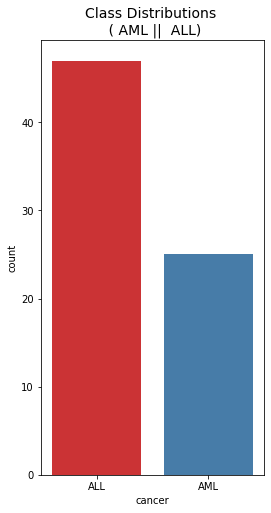

In [ ]:
plt.figure(figsize=(4,8))
colors = ["AML", "ALL"]
sns.countplot('cancer', data=cancer_targets, palette = "Set1")
plt.title('Class Distributions \n ( AML ||  ALL)', fontsize=14)

In [ ]:
Train_Data = pd.read_csv("/content/data_set_ALL_AML_train.csv")
Test_Data = pd.read_csv("/content/data_set_ALL_AML_independent.csv")
labels = pd.read_csv("/content/actual.csv", index_col = 'patient')
Train_Data.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [ ]:
Test_Data.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [ ]:
labels.head()

,cancer
patient,
1,ALL
2,ALL
3,ALL
4,ALL
5,ALL


In [ ]:
labels['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [ ]:
print(Train_Data.isna().sum().max())
print(Test_Data.isna().sum().max())

0
0


In [ ]:
cols = [col for col in Test_Data.columns if 'call' in col]
test = Test_Data.drop(cols, 1)
cols = [col for col in Train_Data.columns if 'call' in col]
train = Train_Data.drop(cols, 1)

<ipython-input-49-866427d165b4>:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

<ipython-input-49-866427d165b4>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
patients = [str(i) for i in range(1, 73, 1)]
df_all = pd.concat([train, test], axis = 1)[patients]
df_all = df_all.T

In [ ]:
df_all.shape

(72, 7129)

In [ ]:
df_all["patient"] = pd.to_numeric(patients)
labels["cancer"]= pd.get_dummies(labels.cancer, drop_first=True)
labels

,cancer
patient,
1,0
2,0
3,0
4,0
5,0
...,...
68,0
69,0
70,0


In [ ]:
Data = pd.merge(df_all, labels, on="patient")
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,7121,7122,7123,7124,7125,7126,7127,7128,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


In [ ]:
Data = Data.sample(frac = 1)

In [ ]:
X, y = Data.drop(columns=["cancer"]), Data["cancer"]

#overall


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.20, random_state= 0)



In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range =(0, 1))

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA() 
# X_train = pca.fit_transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)
# total=sum(pca.explained_variance_)
# k=0
# current_variance=0
# while current_variance/total < 0.75:
#     current_variance += pca.explained_variance_[k]
#     k=k+1
# print(k)    
# k = 20
# print(pca.explained_variance_)

#the main one


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
# search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)
# search.fit(X_train, y_train)

In [ ]:
# best_parameters = search.best_estimator_
# best_parameters

In [ ]:
# from sklearn.metrics import f1_score
# from sklearn.decomposition import NMF
# def model_implement( i, j ,model):
  
#   X_cur = X[:j]
#   y_cur = y[:j]

#   from sklearn.model_selection import train_test_split
#   X_train, X_test, y_train, y_test =  train_test_split(X_cur,y_cur,test_size = 0.20, random_state= 0)
   
#   from sklearn.preprocessing import StandardScaler
#   sc_X = StandardScaler()
#   X_train_scaled = sc_X.fit_transform(X_train.values)
#   X_test_scaled = sc_X.transform(X_test.values) 

#   pca = PCA(n_components = i)
#   X_train_cur = pca.fit_transform(X_train_scaled)
#   X_test_cur = pca.transform(X_test_scaled)
    
#   model.fit(X_train_cur,y_train )
#   y_pred=model.predict(X_test_cur)
    
#   f_1_score = f1_score(y_test, y_pred)
#   balanced_accuracy =   balanced_accuracy_score(y_test, y_pred)


  

#   return f_1_score,balanced_accuracy


In [ ]:
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF
def model_implement( i, j ,model):
  print(i, j)
  X_train_cur = X_train_scaled[:j]
  y_train_cur = y_train[:j]
   
  # pca = PCA(n_components = i)
  # X_train_cur = pca.fit_transform(X_train_cur)
  # X_test_cur = pca.transform(X_test)

  lsa = NMF(n_components=i)
  X_train_cur = lsa.fit_transform(X_train_cur)
  X_test_cur = lsa.transform(X_test_scaled)

  # train_text.np.todense() 
  model.fit(X_train_cur,y_train_cur )
  y_pred=model.predict(X_test_cur)
    
  f_1_score = f1_score(y_test, y_pred)
  # print(y_pred, y_test)
  balanced_accuracy =   balanced_accuracy_score(y_test, y_pred)
  return f_1_score,balanced_accuracy

  

  return f_1_score,balanced_accuracy


In [ ]:
  adhoc_dimension = 12
  # adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
  adhoc_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis = ['Z'])

  adhoc_backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
  )

  adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

  model = SVC(kernel=adhoc_kernel.evaluate)
  print( model_implement(8, 22, model))

8 22


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



(0.0, 0.5)


In [ ]:
import math 
def f_1_score_and_balanced_accuracy_calc_classical(feature, samples):
  
  # model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  #   decision_function_shape='ovr', degree=3, gamma='auto',
  #   kernel='linear', max_iter=-1, probability=False, random_state=None,
  #   shrinking=True, tol=0.001, verbose=False)
  
  
  f_1_score_classical = []
  balanced_accuracy_classical = []
  # i = feature, j = samples
  j = 9
  
  for i in range(2, feature, 6 ):
    x = []
    y = []
    for j in range(25, samples, 11):
      model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto',
              kernel='linear', max_iter=-1, probability=False, random_state=None,
              shrinking=True, tol=0.001, verbose=False)
      fone_score, balanced_accuracy = model_implement(i, j, model)
      x.append(fone_score)
      y.append(balanced_accuracy)
    f_1_score_classical.append(x)
    balanced_accuracy_classical.append(y)
  return pd.DataFrame(f_1_score_classical), pd.DataFrame(balanced_accuracy_classical)


In [ ]:
import math 
def f_1_score_and_balanced_accuracy_calc_quantum(feature, samples):
  
  # adhoc_dimension = 20
  # # adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
  # adhoc_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis = ['Z'])

  # adhoc_backend = QuantumInstance(
  #   BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
  # )

  # adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

  # model = SVC(kernel=adhoc_kernel.evaluate)
  
  
  
  f_1_score_quantum = []
  balanced_accuracy_quantum = []
  # i = feature, j = samples
  j = 9
  
  for i in range(2, feature, 6  ):
    x = []
    y = []
    for j in range(25, samples, 11):
      adhoc_dimension = i
      # adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
      adhoc_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis = ['Z'])

      adhoc_backend = QuantumInstance(
        BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
      )

      adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

      model = SVC(kernel=adhoc_kernel.evaluate)
      fone_score, balanced_accuracy = model_implement(i, j, model)
      x.append(fone_score)
      y.append(balanced_accuracy)
    f_1_score_quantum.append(x)
    balanced_accuracy_quantum.append(y)
  return pd.DataFrame(f_1_score_quantum), pd.DataFrame(balanced_accuracy_quantum)


In [ ]:
import math 
def f_1_score_and_balanced_accuracy_calc_qsvc(feature, samples):
  
  # adhoc_dimension = 20
  # # adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
  # adhoc_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis = ['Z'])

  # adhoc_backend = QuantumInstance(
  #   BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
  # )

  # adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

  # model= QSVC(quantum_kernel=adhoc_kernel)
  
  
  
  f_1_score_quantum = []
  balanced_accuracy_quantum = []
  # i = feature, j = samples
  j = 9
  
  for i in range(2, feature, 6  ):
    x = []
    y = []
    for j in range(25, samples, 11):
      adhoc_dimension = i
      # adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
      adhoc_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis = ['Z'])

      adhoc_backend = QuantumInstance(
        BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
      )

      adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

      model= QSVC(quantum_kernel=adhoc_kernel)
      fone_score, balanced_accuracy = model_implement(i, j, model)
      x.append(fone_score)
      y.append(balanced_accuracy)
    f_1_score_quantum.append(x)
    balanced_accuracy_quantum.append(y)
  return pd.DataFrame(f_1_score_quantum), pd.DataFrame(balanced_accuracy_quantum)


#kernel matrix drawing

In [ ]:
# adhoc_dimension, i  = 15,15
# adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

# adhoc_backend = QuantumInstance(
#     BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
#   )

# adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

# model = SVC(kernel=adhoc_kernel.evaluate)
  
# pca = PCA(n_components =i )
# X_train_cur = pca.fit_transform(X_train)
# X_test_cur = pca.transform(X_test)
    
# model.fit(X_train_cur,y_train )
# y_pred=model.predict(X_test_cur)
# score = model.score(X_test_cur, y_test)
    
# f_1_score = f1_score(y_test, y_pred)
# balanced_accuracy =   balanced_accuracy_score(y_test, y_pred)
# print(score, f_1_score, balanced_accuracy)

# adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=X_train_cur)
# adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=X_test_cur,
#                                           y_vec=X_train_cur)

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(np.asmatrix(adhoc_matrix_train),
#               interpolation='nearest', origin='upper', cmap='Blues')
# axs[0].set_title("gene expression training kernel matrix")
# axs[1].imshow(np.asmatrix(adhoc_matrix_test),
#               interpolation='nearest', origin='upper', cmap='Reds')
# axs[1].set_title("gene expression testing kernel matrix")
# plt.show()

# adhoc_svc = SVC(kernel='precomputed')
# adhoc_svc.fit(adhoc_matrix_train, y_train)
# adhoc_score = adhoc_svc.score(adhoc_matrix_test, y_test)

# print(f'Precomputed kernel classification test score: {adhoc_score}')


In [ ]:
# print(np.asmatrix(adhoc_matrix_train))

In [ ]:
# print(np.asmatrix(adhoc_matrix_test))

#REST

In [ ]:

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt





feature , samples = 20,58
f_1_score_classical , balanced_accuracy_classical= f_1_score_and_balanced_accuracy_calc_classical(feature,samples)
f_1_score_quantum, balanced_accuracy_quantum = f_1_score_and_balanced_accuracy_calc_quantum(feature,samples)
z_f1_c = f_1_score_classical.values
z_f1_q = f_1_score_quantum.values


z_ba_c = balanced_accuracy_classical.values
z_ba_q = balanced_accuracy_quantum.values
sh_0 , sh_1 = z_f1_c.shape
x, y = np.linspace(2, 20,sh_0 ), np.linspace(22,58,sh_1)


fig = go.Figure(data=[
    go.Surface(z=z_f1_c, x = x, y = y ,name="clasical", colorscale ='earth',opacity = 0.9),
    go.Surface(z=z_f1_q, x=x, y=y,name="quantum", colorscale ='HOT')
    

])



fig.show()

2 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



2 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



2 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



8 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



8 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



8 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



14 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



2 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



2 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



2 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



8 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



8 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



8 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [ ]:
print(z_f1_c)

[[0.25       0.44444444 0.        ]
 [0.83333333 1.         1.        ]
 [0.90909091 0.90909091 0.90909091]]


In [ ]:
print(z_f1_q)

[[0.         0.         0.        ]
 [0.         0.5        0.25      ]
 [0.         0.         0.28571429]]


In [ ]:
fig = go.Figure(data=[
    go.Surface(z=z_ba_c, x = x, y = y,name = "classical", colorscale ='earth'),
    go.Surface(z=z_ba_q, x=x, y=y,name = "quantum", colorscale ='HOT'),
    

])



fig.show()

In [ ]:
print(z_ba_c)

[[0.52777778 0.61111111 0.5       ]
 [0.86111111 1.         1.        ]
 [0.91666667 0.91666667 0.91666667]]


In [ ]:
print(z_ba_q)

[[0.44444444 0.5        0.5       ]
 [0.5        0.66666667 0.52777778]
 [0.5        0.5        0.58333333]]


In [ ]:

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt





feature , samples = 20,58
f_1_score_classical , balanced_accuracy_classical= f_1_score_and_balanced_accuracy_calc_classical(feature,samples)
f_1_score_quantum, balanced_accuracy_quantum = f_1_score_and_balanced_accuracy_calc_qsvc(feature,samples)
z_f1_c = f_1_score_classical.values
z_f1_q = f_1_score_quantum.values


z_ba_c = balanced_accuracy_classical.values
z_ba_q = balanced_accuracy_quantum.values
sh_0 , sh_1 = z_f1_c.shape
x, y = np.linspace(2, 20,sh_0 ), np.linspace(22,58,sh_1)


fig = go.Figure(data=[
    go.Surface(z=z_f1_c, x = x, y = y ,name="clasical", colorscale ='earth',opacity = 0.9),
    go.Surface(z=z_f1_q, x=x, y=y,name="quantum", colorscale ='HOT')
    

])



fig.show()

2 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



2 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



2 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



8 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



8 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



8 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



14 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



14 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



14 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



2 25
2 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



2 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



8 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



8 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



8 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 25


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 36


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



14 47


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



In [ ]:
fig = go.Figure(data=[
    go.Surface(z=z_ba_c, x = x, y = y,name = "classical", colorscale ='earth'),
    go.Surface(z=z_ba_q, x=x, y=y,name = "quantum", colorscale ='HOT'),
    

])



fig.show()

#PTRI

In [ ]:
def model_implement(model , feature, samples):
  f_1_score = {}
  # i = feature, j = samples
  
  
  for i in range(2, feature, 6 ):
    for j in range(22, samples, 6):
      x_dis = [-1, -1,-1,0, 0, 1, 1, 1,0]
      y_dis = [-1, 0, 1, -1, 1,-1,0, 1,0]
    
      for m, n in zip(x_dis, y_dis):
        # X_train_cur = X_train[:j+n]
        # y_train_cur = y_train[:j+n]
        X_train_cur = X_train_scaled[:j+n]
        y_train_cur = y_train[:j+n]
   
        # pca = PCA(n_components = i+m)
        # X_train_cur = pca.fit_transform(X_train_cur)
        # X_test_cur = pca.transform(X_test)
        lsa = NMF(n_components=i, init='random', random_state=0)
        X_train_cur = lsa.fit_transform(X_train_cur)
        X_test_cur = lsa.transform(X_test_scaled)
        
        model.fit(X_train_cur,y_train_cur )
        y_pred=model.predict(X_test_cur)
    
        f_1_score[(i+m, j+n)] = f1_score(y_test, y_pred, average='binary')
    
  return f_1_score

def ptri_score(model , feature, samples):
  ptri_score = []
  import math 
  f1_score_dict = model_implement(model, feature, samples)
  
  for i in range(2, feature, 6 ):
    x = []
    for j in range(22, samples, 6):
      x.append(math.sqrt((f1_score_dict[(i,j)] - f1_score_dict[(i-1,j-1)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i-1,j)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i-1,j+1)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i,j-1)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i,j+1)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i+1,j-1)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i+1,j)])**2+
                             (f1_score_dict[(i,j)] - f1_score_dict[(i+1,j+1)])**2)
      )
      print(i,j)
    ptri_score.append(x)
  return pd.DataFrame(ptri_score)






In [ ]:
model_c_svm = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

adhoc_dimension = 20
# adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")
adhoc_feature_map = PauliFeatureMap(feature_dimension=adhoc_dimension, reps=2, paulis = ['Z'])

adhoc_backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
  )

adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=adhoc_backend)

model_q_svm = SVC(kernel=adhoc_kernel.evaluate)



import plotly.graph_objects as go
import numpy as np
k = 20
feature , samples =k,58
ptri_score_dict_classical = ptri_score(model_c_svm, feature,samples)
ptri_score_dict_quantum = ptri_score(model_q_svm, feature,samples)
z1 = ptri_score_dict_classical.values
z2 = ptri_score_dict_quantum.values
sh_0 , sh_1 = z1.shape
x, y = np.linspace(2, feature,sh_0 ), np.linspace(22,samples,sh_1)


fig = go.Figure(data=[
    go.Surface(z=z1, x = x, y = y,name = "classical", colorscale ='earth'),
    go.Surface(z=z2, x=x, y=y,name = "quantum", colorscale ='HOT'),
    

])

fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 

2 22
2 28
2 34
2 40
2 46
2 52
8 22
8 28
8 34
8 40
8 46
8 52
14 22
14 28
14 34
14 40
14 46
14 52


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 

2 22
2 28
2 34
2 40
2 46
2 52
8 22
8 28
8 34
8 40
8 46
8 52
14 22
14 28
14 34
14 40
14 46
14 52
